In [1]:
%matplotlib inline

import pickle
import numpy as np
import astropy.units as u
from astropy.time import Time
from pathlib import Path
import pulsarbat as pb
import scipy.signal
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm

from IPython.display import HTML
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

_ = plt.ioff()


LATEX_PREAMBLE = r"""
\usepackage{amsmath}
\usepackage{amssymb}
\usepackage{times}
\usepackage{siunitx}
\renewcommand\ttdefault{cmvtt}
\DeclareSIUnit \parsec {pc}
"""

plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=LATEX_PREAMBLE)
plt.rc('font', family='serif')
plt.rc('font', size=16)

# Measuring excess DM using giant pulses

**Problem:** We have detected a bright giant pulse across multiple frequency bands and find that the DM was incorrectly measured!

In [2]:
import scipy.signal

folder = Path("C:/Users/Nikhil/Desktop/gp_spec")

def pickle_load(filename):
    """Loads any data from file via unpickling. Use at your own risk!"""
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

z = pickle_load(folder / "SVD_GP_BINNED.pb")

sos = scipy.signal.butter(10, 0.8, 'lowpass', output='sos')
x = scipy.signal.sosfilt(sos, z.data, axis=0)
z = pb.BasebandSignal.like(z, x)[32:-32]
z = z.to_intensity()
z = type(z).like(z, z.data.mean(-1))

print(z)

IntensitySignal @ 0x27220b1e1f0
-------------------------------
Data Container: numpy.ndarray<shape=(4032, 19), dtype=float64>
Sample rate: 3.125 MHz
Time length: 0.00129024 s
Start time: 2018-05-07T08:13:55.908958113
Channel Bandwidth: 3.125 MHz
Total Bandwidth: 59.375 MHz
Center Frequency: 327.0 MHz



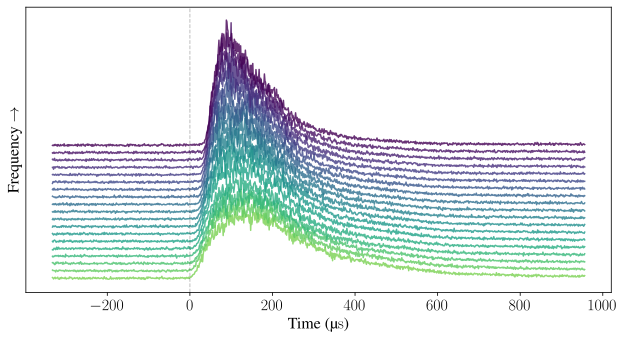

In [3]:
x = z.data.reshape(-1, 4, 19).mean(1)
x -= x[:250].mean(0)[None]

freqs = z.channel_freqs
taus = (np.arange(len(x)) - 260) * (4 * 0.32)

colors = cm.viridis(np.linspace(0.0, 0.8, 19))[::-1]

plt.close()
plt.figure(figsize=(9, 5), tight_layout=True)
for i in range(19):
    plt.plot(taus, (1000 * x[..., i]) + i/20, '-', color=colors[i], alpha=0.8)
plt.axvline(0, color='k', alpha=0.25, ls='--', lw=1)
plt.xlabel(r"Time (\unit{\micro\second})")
plt.yticks([])
plt.ylabel(r"Frequency $\rightarrow$")
plt.show()

The plot above shows the intensity of a scattered giant pulse (frequency increases upwards) that we start out with. As we can see (with the help of the vertical line as a visual aid), the pulse intensity starts rising at later times at higher frequencies. This indicates that there is a negative excess DM (the original DM used was too high - estimated by observing the folded profile of the regular pulse emission).

---

Usually, the DM is measured by aligning the peak intensity across frequency. But this can lead to incorrect DM measurement especially if you have additional chromatic effects such as interstellar scattering or intrinsic changes in the profile. The ideal way to measure DM would be to align the "beginning" of a sharp impulse. In most cases, this is difficult to measure because there is no good way to define where a pulse/signal "begins" and it's not necessarily true that the signal was emitted at the same time across the frequency band.

With giant pulses (which are impulsive by nature), it is possible to do this! We should be able to measure the "rise location" for each frequency and fit a DM curve to it. We can also be relatively confident that giant pulse signal was emitted at the same time across the frequency band.

### Data

In this notebook, I use the average intensity of [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition)-combined phase-aligned giant pulses (using baseband/voltage data) from an Arecibo observation of PSR B1937+21. I generate intensity data for 19 contiguous frequency bands of bandwidth 3.125 MHz, centered at 327 MHz (from 297.3125 MHz to 356.6875 MHz).

In practice, this should be the same as using the intensity data of a single very bright scattered impulse (giant pulse or FRB).

## Trial-and-error DM correction

One quick way to estimate the excess DM would be to dedisperse the giant pulse with many different DMs and picking the best one.

If we use the center of our frequency bands as the reference frequency, then over-dispersing (using a DM that is too high) will result in high frequencies arriving earlier and under-dispersing (using a DM too low) will result in low frequencies arriving earlier.

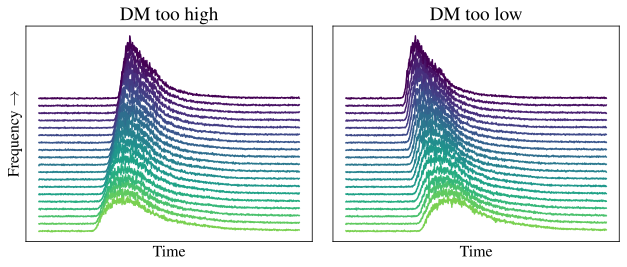

In [4]:
colors = cm.viridis(np.linspace(0.0, 0.8, 19))[::-1]

plt.close()
fig, axes = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True, sharey=True)

y = pb.incoherent_dedispersion(z, pb.DispersionMeasure(6E-3))
y = y[:4*(len(y)//4)]
x = y.data.reshape(-1, 4, 19).mean(1)
x -= x[:100].mean(0)[None]

for i in range(19):
    axes[0].plot((1000 * x[..., i]) + i/10, '-', color=colors[i])
axes[0].set_xlabel(r"Time")
axes[0].set_yticks([])
axes[0].set_xticks([])
axes[0].set_ylabel(r"Frequency $\rightarrow$")
axes[0].set_title("DM too high")


y = pb.incoherent_dedispersion(z, pb.DispersionMeasure(-8E-3))
y = y[:4*(len(y)//4)]
x = y.data.reshape(-1, 4, 19).mean(1)
x -= x[:100].mean(0)[None]

for i in range(19):
    axes[1].plot((1000 * x[..., i]) + i/10, '-', color=colors[i])
axes[1].set_xlabel(r"Time")
axes[1].set_yticks([])
axes[1].set_xticks([])
axes[1].set_title("DM too low")

plt.show()

If we try a bunch of different DMs, we can estimate the excess DM by finding the value at which the pulse is pushed the most to the right (such that all frequencies arrive at the same time and therefore, the average intensity across all frequencies arrives as late as possible).

Here I incoherently dedisperse the giant pulse intensity with a few different trial DMs and align them.

In [5]:
t0 = Time("2018-05-07T08:13:55.909000033", format='isot', precision=9)

dms = np.linspace(-5E-3, 1E-3, 241)
dm0 = dms[0] - (dms[1] - dms[0])/2
dm1 = dms[-1] + (dms[1] - dms[0])/2

im = np.zeros((len(dms), 1024), dtype=np.float32)

for i, dm in enumerate(tqdm(dms)):
    DM = pb.DispersionMeasure(dm)
    y = pb.incoherent_dedispersion(z, DM)
    j = np.int64(np.rint(((t0 - y.start_time) / y.dt).to_value(u.one)))
    im[i] = y.data[j:j+1024].mean(-1)

  0%|          | 0/241 [00:00<?, ?it/s]

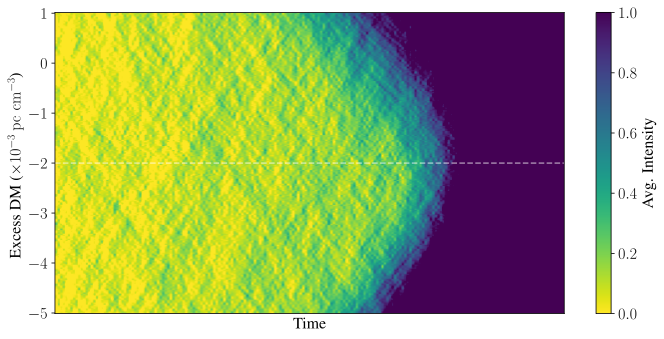

In [6]:
plt.close()
plt.figure(figsize=(10, 5), tight_layout=True)

x = im - im[..., :750].mean(-1)[:, None]

plt.imshow(x[:, -200:]*50000, aspect='auto', origin='lower', vmax=1, vmin=0,
           extent=(0, 1, dm0*1000, dm1*1000), cmap='viridis_r')

plt.axhline(-2, color='w', ls='--', alpha=0.5)

cbar = plt.colorbar()
cbar.set_label(r"Avg. Intensity")

plt.xlabel(r"Time")
plt.xticks([])
plt.ylabel(r"Excess DM ($\times 10^{-3}$ \unit{\parsec \, \, \cm^{-3}})")
plt.show()

The color range has been manually tuned so that the "rise location" of the pulse can be easily determined visually.

As expected, the closer we get to the correct DM, the later the overall intensity starts rising. By visual inspection, we can estimate that the excess DM is approximately $-2 \times 10^{-3} \mathrm{pc} \, \, \mathrm{cm}^{-3}$ (the dashed horizontal line). This is not a very precise measurement.

A better method would involve actually measuring the "rise location" of the pulse at each frequency independently and using fitting routines to solve for the excess DM.

## 5-sigma rise

One simple way to detect where the signal "begins" would be to quite literally find the earliest time at which the signal intensity rises by more than 5 standard deviations relative to the off-pulse region before the pulse.

Here's an example:

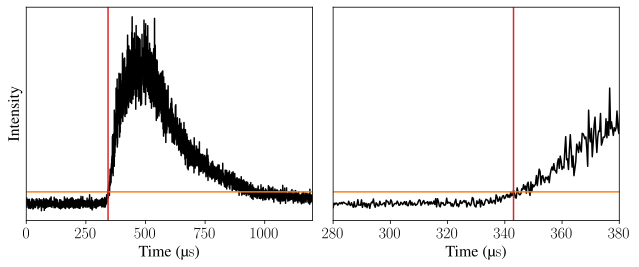

In [7]:
plt.close()

fig, axes = plt.subplots(1, 2, figsize=(9, 4), tight_layout=True, sharey=True)

x = z.data
t = (np.arange(len(x))) * 0.32
x = x[..., 0]
noise = x[:900].mean()
noise_std = x[:900].std()
thres = noise + 5*noise_std
rise = t[np.argwhere(x > thres).squeeze()[0]]

for ax in axes:
    ax.plot(t, x, 'k-')
    ax.axhline(thres, color='C1')
    ax.axvline(rise, color='C3')
    ax.set_yticks([])
    ax.set_xlabel(r"Time (\unit{\micro\second})")

axes[0].set_xlim(0, 1200)
axes[1].set_xlim(280, 380)
axes[0].set_ylabel("Intensity")

plt.show()

The horizontal orange line shows the 5-sigma threshold of the off-pulse region to the left of the pulse. The red vertical line indicates the earliest point at which the pulse intensity rises above the threshold. The plot on the right shows a zoomed-in view of the left plot.

Using this simple technique, we can find the rise times of the pulse at each frequency and fit a DM to the curve (via simple linear least-squares fitting)!

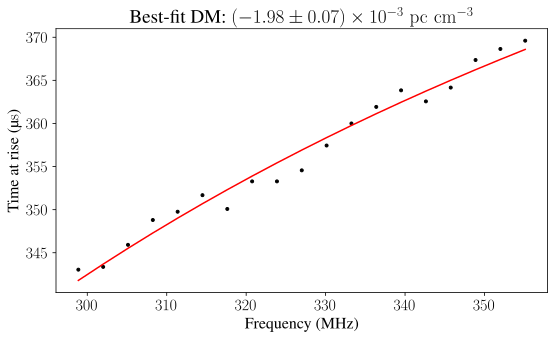

In [8]:
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

x = uniform_filter1d(z.data, 1, axis=0)
t = (np.arange(len(x))) * 0.32

x0s = np.zeros(19)

for i in range(19):
    noise = x[:900, i].mean()
    noise_std = x[:900, i].std()
    thres = noise + 5*noise_std
    x0s[i] = t[np.argwhere(x[..., i] > thres).squeeze()[0]]


def func(fs, dm, c):
    DM = pb.DispersionMeasure(dm)
    ts = DM.time_delay(fs * u.MHz, 327 * u.MHz).to_value(u.us)
    return ts + c

fs = z.channel_freqs.to_value(u.MHz)
p0, pcov = curve_fit(func, fs, x0s, p0=(-2E-3, 365))
dm0 = p0[0] * 1000
dm0_err = np.sqrt(np.diag(pcov))[0] * 1000

plt.close()
plt.figure(figsize=(8, 5), tight_layout=True)
plt.plot(fs, x0s, 'k.')
plt.plot(fs, func(fs, *p0), 'r-')
plt.xlabel("Frequency (MHz)")
plt.ylabel(r"Time at rise (\unit{\micro\second})")
plt.title(rf"Best-fit DM: $({dm0:.2f} \pm {dm0_err:.2f}) \times 10^{{-3}} \, \, \mathrm{{pc}} \, \, \mathrm{{cm}}^{{-3}}$")
plt.show()

This technique gives a quick and dirty answer. However, it has a few flaws. The "rise location" is heavily influenced by random noise which can lead to an earlier or later rise location being measured. In our example, we see that the pulse rises faster higher frequencies and slower at lower frequencies. This can introduce a bias as it preferentially detects a later rise location at low frequencies. This introduces a bias towards higher DMs.

We can use boxcar smoothing to counter-act this bias and get a better measurement of the excess DM. Let's apply a box-car filter of length 2 points to smooth out the data.

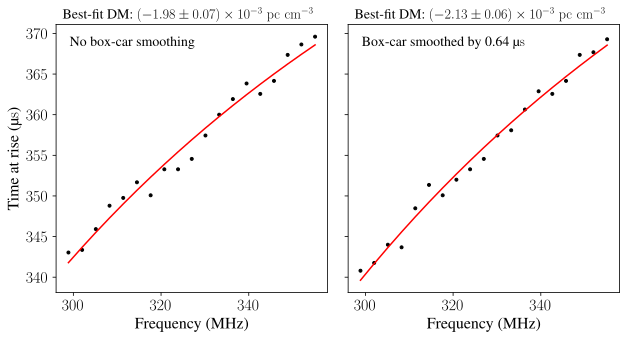

In [9]:
from scipy.optimize import curve_fit
from scipy.ndimage import uniform_filter1d

def filtered_x0s(z, size):
    x = uniform_filter1d(z, size, axis=0)
    t = (np.arange(len(x))) * 0.32

    x0s = np.zeros(19)

    for i in range(19):
        noise = x[:900, i].mean()
        noise_std = x[:900, i].std()
        thres = noise + 5*noise_std
        x0s[i] = t[np.argwhere(x[..., i] > thres).squeeze()[0]]

    return x0s
        

def func(fs, dm, c):
    DM = pb.DispersionMeasure(dm)
    ts = DM.time_delay(fs * u.MHz, 327 * u.MHz).to_value(u.us)
    return ts + c

fs = z.channel_freqs.to_value(u.MHz)

plt.close()
fig, axes = plt.subplots(1, 2, figsize=(9, 5), tight_layout=True, sharex=True, sharey=True)

ax = axes[0]

x0s = filtered_x0s(z.data, 1)
p0, pcov = curve_fit(func, fs, x0s, p0=(-2E-3, 365))
dm0 = p0[0] * 1000
dm0_err = np.sqrt(np.diag(pcov))[0] * 1000

ax.plot(fs, x0s, 'k.')
ax.plot(fs, func(fs, *p0), 'r-')
ax.set_xlabel("Frequency (MHz)")
ax.set_ylabel(r"Time at rise (\unit{\micro\second})")
ax.set_title(rf"Best-fit DM: $({dm0:.2f} \pm {dm0_err:.2f}) \times 10^{{-3}} \, \, \mathrm{{pc}} \, \, \mathrm{{cm}}^{{-3}}$", fontsize=14)
ax.text(0.05, 0.92, rf"No box-car smoothing", fontsize=14,  transform=ax.transAxes)

ax = axes[1]

x0s = filtered_x0s(z.data, 2)
p0, pcov = curve_fit(func, fs, x0s, p0=(-2E-3, 365))
dm0 = p0[0] * 1000
dm0_err = np.sqrt(np.diag(pcov))[0] * 1000

ax.plot(fs, x0s, 'k.')
ax.plot(fs, func(fs, *p0), 'r-')
ax.text(0.05, 0.92, rf"Box-car smoothed by {0.32*2:.2f} \unit{{\micro\second}}", fontsize=14,  transform=ax.transAxes)
ax.set_xlabel("Frequency (MHz)")
ax.set_title(rf"Best-fit DM: $({dm0:.2f} \pm {dm0_err:.2f}) \times 10^{{-3}} \, \, \mathrm{{pc}} \, \, \mathrm{{cm}}^{{-3}}$", fontsize=14)

plt.show()

In the above comparison, we can see that applying the smoothing leads to earlier detection of rise locations at lower frequencies, which leads to a lower excess DM being measured. This new measurement is more robust and trustworthy (The residuals appear to be much smaller too).

---

*I'll keep updating this notebook as I come across better or more interesting ways to measure DM in the case of really bright bursts such as giant pulses.*